# Parameter Inference and Calibration: Linking UER to GDP

View target demand as input to the model (instead of a stylized sinusoidal business cycle). 

I see two possible options:
1. GDP growth in line with Okun's Law specifically for unemployment - a 1% change in GDP: 0.03-0.05% change in UER
2. Growth in target demand


In [1]:
# Import packages
from abm_funs import *
from plot_funs import *
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
import tempfile
import pyabc
from scipy.stats import pearsonr, linregress
from pyabc.visualization import plot_kde_matrix, plot_kde_1d
import math as math
from pyabc.transition import MultivariateNormalTransition
import seaborn as sns
from IPython.display import display
from PIL import Image
from pstats import SortKey
import datetime
from collate_macro_vars import *
from statsmodels.tsa.filters import hp_filter, bk_filter, cf_filter
from quantecon import hamilton_filter
from statsmodels.tsa.seasonal import seasonal_decompose
import csv
from dtaidistance import dtw
from functools import partial

rng = np.random.default_rng()
test_fun()

path: "~/"

import os
print(os.cpu_count()) 

calib = True
save = True

NEW Function import successful
8


In [2]:
#realgdp = macro_observations[["DATE", "REALGDP"]].dropna(subset=["REALGDP"]).reset_index()
realgdp['log_REALGDP'] = np.log2(realgdp['REALGDP'])

# GDP Filter
cycle, trend = hp_filter.hpfilter(realgdp['log_REALGDP'], lamb=129600)
 
# Adding the trend and cycle to the original DataFrame
realgdp['log_Trend'] = trend+1
realgdp['log_Cycle'] = cycle+1
realgdp['Trend'] = np.exp(trend)
realgdp['Cycle'] = np.exp(cycle)

realgdp_no_covid = realgdp[realgdp['DATE'] < "2019-10-1"].copy()
realgdp['scaled_log_Cycle'] = (realgdp['log_Cycle'] - realgdp['log_Cycle'].min()) / (realgdp['log_Cycle'].max() - realgdp['log_Cycle'].min())
realgdp_no_covid['scaled_log_Cycle'] = (realgdp_no_covid['log_Cycle'] - realgdp_no_covid['log_Cycle'].min()) / (realgdp_no_covid['log_Cycle'].max() - realgdp_no_covid['log_Cycle'].min())

In [3]:
k = 12
bk_cycle = bk_filter.bkfilter(realgdp['log_REALGDP'], low=6, high=32, K=k) + 1
padded_series = pd.Series(
    [np.nan]*k + list(bk_cycle) + [np.nan]*k,
    index=realgdp.index  
)

# Add it to the DataFrame
realgdp['bk_gdp'] = padded_series


In [4]:
k = 12
cf_cycle = cf_filter.cffilter(realgdp['log_REALGDP'], low=6, high=32, drift = True)[0] + 1
# Add it to the DataFrame
realgdp['cf_gdp'] = cf_cycle


In [5]:
# 8 recommended for quarterly data: https://quanteconpy.readthedocs.io/en/latest/tools/filter.html
H = 8
hamilton_cycle = hamilton_filter(realgdp['log_REALGDP'], h = H)[0] + 1

# Add it to the DataFrame
realgdp['hamilton_gdp'] = hamilton_cycle

/var/folders/34/6r0xdq916zn1qsvypkxnsqkw0000gr/T/ipykernel_38361/540905770.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['OBS_VALUE'] = hp_filter.hpfilter(subset['OBS_VALUE'], lamb=1600)[0]*.01+1


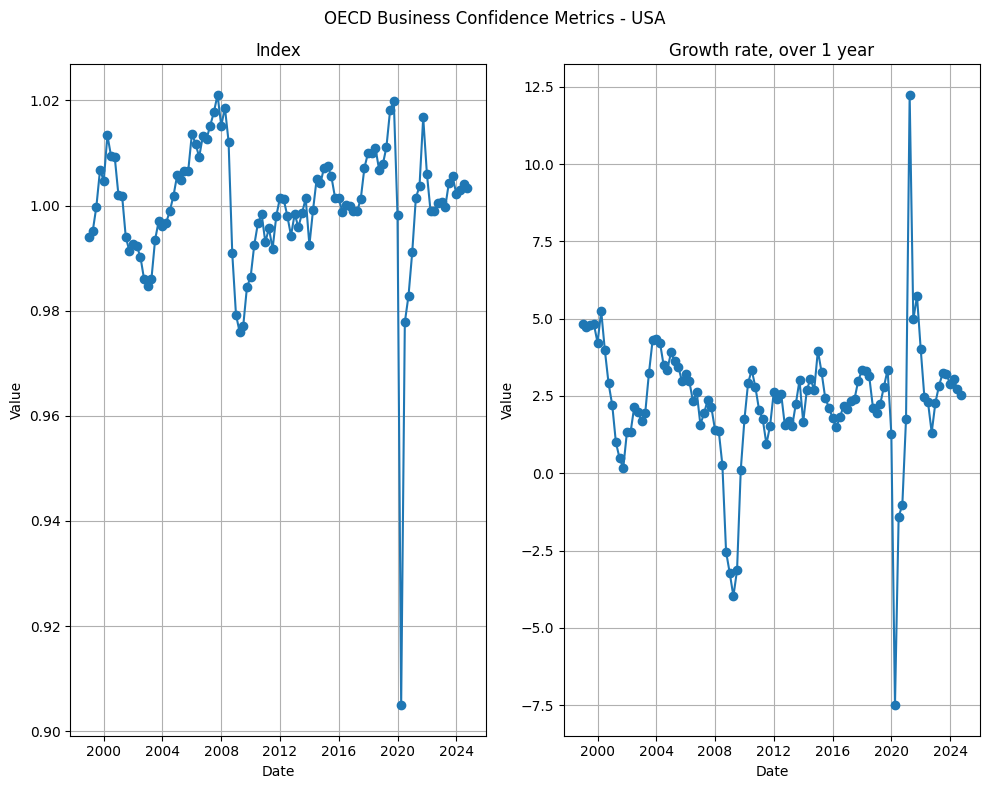

In [6]:
# Load and clean OECD business confidence data
# Source: https://www.oecd.org/en/data/indicators/business-confidence-index-bci.html
bus_conf = pd.read_csv(path + "data/macro_vars/OECD_bus_conf_usa.csv")
bus_conf = bus_conf.loc[:, bus_conf.nunique() > 1]  # fix: assign back
bus_conf['DATE'] = pd.PeriodIndex(bus_conf['TIME_PERIOD'], freq='Q').start_time
bus_conf = bus_conf.sort_values(by='DATE')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

# Plot each transformation type
for i, index_type in enumerate(bus_conf['Transformation'].unique()):
    subset = bus_conf[bus_conf['Transformation'] == index_type]
    if index_type == "Index":
        subset['OBS_VALUE'] = hp_filter.hpfilter(subset['OBS_VALUE'], lamb=1600)[0]*.01+1
    ax = axes[i]  # fix: access subplot properly
    ax.plot(subset['DATE'], subset['OBS_VALUE'], marker='o')
    ax.set_title(f'{index_type}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.grid(True)

plt.suptitle('OECD Business Confidence Metrics - USA')
plt.tight_layout()
plt.show()

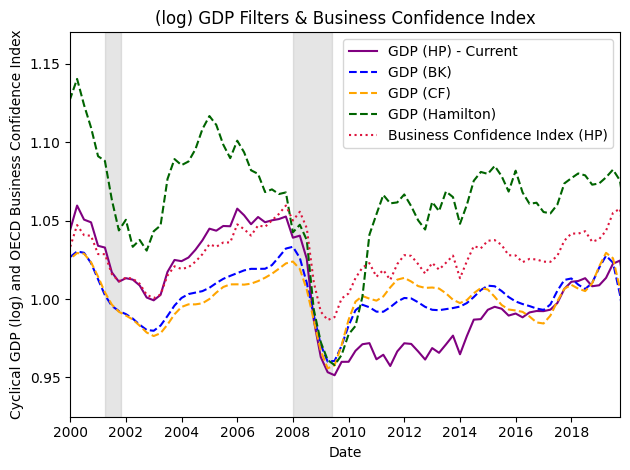

In [7]:
#realgdp = macro_observations[["DATE", "REALGDP"]].dropna(subset=["REALGDP"]).reset_index()
realgdp['log_REALGDP'] = np.log2(realgdp['REALGDP'])

# GDP Filter
cycle, trend = hp_filter.hpfilter(realgdp['log_REALGDP'], lamb=129600)
 
# Adding the trend and cycle to the original DataFrame
realgdp['log_Trend'] = trend+1
realgdp['log_Cycle'] = cycle+1
realgdp['Trend'] = np.exp(trend)
realgdp['Cycle'] = np.exp(cycle)

realgdp_no_covid = realgdp[realgdp['DATE'] < "2019-10-1"].copy()
realgdp['scaled_log_Cycle'] = (realgdp['log_Cycle'] - realgdp['log_Cycle'].min()) / (realgdp['log_Cycle'].max() - realgdp['log_Cycle'].min())
realgdp_no_covid['scaled_log_Cycle'] = (realgdp_no_covid['log_Cycle'] - realgdp_no_covid['log_Cycle'].min()) / (realgdp_no_covid['log_Cycle'].max() - realgdp_no_covid['log_Cycle'].min())

k = 12
bk_cycle = bk_filter.bkfilter(realgdp['log_REALGDP'], low=6, high=32, K=k) + 1
padded_series = pd.Series(
    [np.nan]*k + list(bk_cycle) + [np.nan]*k,
    index=realgdp.index  
)

# Add it to the DataFrame
realgdp['bk_gdp'] = padded_series

k = 12
cf_cycle = cf_filter.cffilter(realgdp['log_REALGDP'], low=6, high=32, drift = True)[0] + 1
# Add it to the DataFrame
realgdp['cf_gdp'] = cf_cycle

# 8 recommended for quarterly data: https://quanteconpy.readthedocs.io/en/latest/tools/filter.html
H = 8
hamilton_cycle = hamilton_filter(realgdp['log_REALGDP'], h = H)[0] + 1

# Add it to the DataFrame
realgdp['hamilton_gdp'] = hamilton_cycle

# Extract and filter business confidence "Index"
bus_conf_index = bus_conf[bus_conf['Transformation'] == "Index"].copy()
bus_conf_index['OBS_VALUE'] = hp_filter.hpfilter(bus_conf_index['OBS_VALUE'], lamb=1600)[0]

# OPTIONAL: Normalize or scale to GDP cycle range if needed (for better visual comparison)
bus_conf_index['OBS_VALUE_scaled'] = (
    (bus_conf_index['OBS_VALUE'] - bus_conf_index['OBS_VALUE'].min()) /
    (bus_conf_index['OBS_VALUE'].max() - bus_conf_index['OBS_VALUE'].min())
) * (realgdp['log_Cycle'].max() - realgdp['log_Cycle'].min()) + realgdp['log_Cycle'].min()

# Main axis
fig, ax1 = plt.subplots()

# Plot on main axis
line1, = ax1.plot(realgdp['DATE'], realgdp['log_Cycle'], label="GDP (HP) - Current", color="purple")
line2, = ax1.plot(realgdp['DATE'], realgdp['bk_gdp'], label="GDP (BK)", color="blue", linestyle="dashed")
line3, = ax1.plot(realgdp['DATE'], realgdp['cf_gdp'], label="GDP (CF)", color="orange", linestyle="dashed")
line4, = ax1.plot(realgdp['DATE'], realgdp['hamilton_gdp'], label="GDP (Hamilton)", color="darkgreen", linestyle="dashed")
line5, = ax1.plot(bus_conf_index['DATE'], bus_conf_index['OBS_VALUE_scaled'],
    label="Business Confidence Index (HP)",
    color="crimson",
    linestyle="dotted"
)
ax1.set_ylabel("Cyclical GDP (log) and OECD Business Confidence Index")
ax1.set_ylim([0.925, 1.17])

# Set common attributes
ax1.set_xlim([datetime.date(2000, 1, 1), datetime.date(2019, 10, 1)])
ax1.set_title("(log) GDP Filters & Business Confidence Index")
ax1.set_xlabel("Date")

ax1.fill_between(
    recessions['DATE'], 0, 1,
    where=recessions['USREC'] == 1,
    transform=ax1.get_xaxis_transform(),
    color='grey', alpha=0.2, label='Recession'
)
# Combine legends
lines = [line1, line2, line3, line4, line5]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()



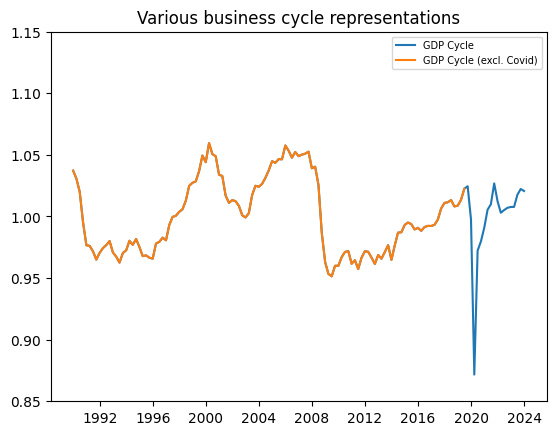

In [8]:
t = np.arange(0,len(realgdp['DATE']),1)
#bus_cycle = bus_cycle_demand(0.5, t, 1, 30)

#plt.plot(realgdp['DATE'], bus_cycle, label = "Stylised Sinusoidal Business Cycle")
plt.plot(realgdp['DATE'], realgdp['log_Cycle'], label = "GDP Cycle")
plt.plot(realgdp_no_covid['DATE'], realgdp_no_covid['log_Cycle'], label = "GDP Cycle (excl. Covid)")
#plt.plot(np.arange(0,78,1), gdp_dat, label = "Calib Period" )
plt.legend(fontsize=7)
plt.ylim([0.85,1.15])
plt.title("Various business cycle representations")

plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

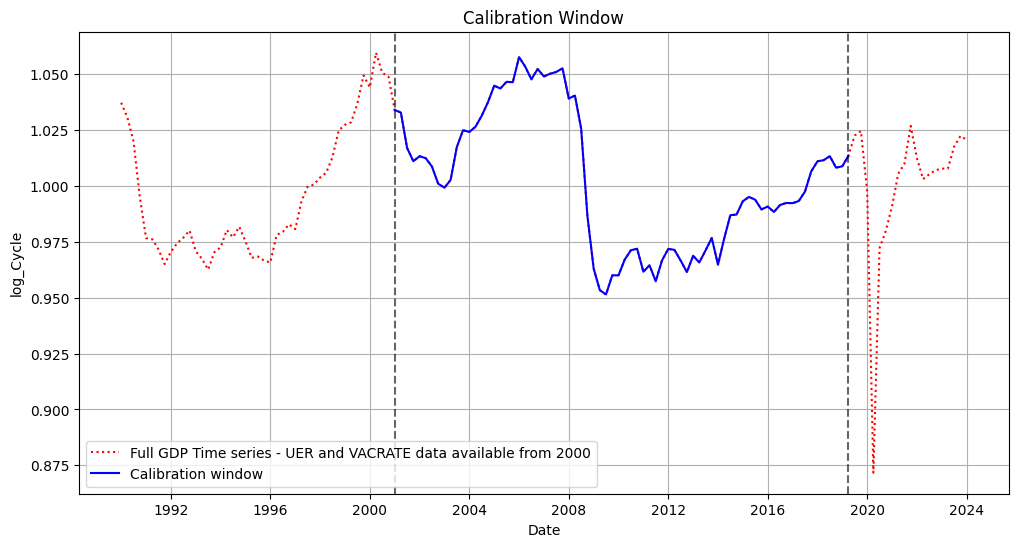

In [9]:
# Different calibration windoes
# Full time series: "2024-5-1"
# calib_date = ["2004-12-01", "2019-05-01"]
calib_date = ["2000-12-01", "2019-05-01"]
# calib_date = ["2000-12-01", "2024-05-01"]
gdp_dat_pd = realgdp[(realgdp['DATE'] >= calib_date[0]) & (realgdp['DATE'] <= calib_date[1])]
#gdp_dat = np.array(gdp_dat_pd['scaled_log_Cycle'])# *0.06

# PLOTTING
plt.figure(figsize=(12, 6))

# Plot original data
sns.lineplot(data = realgdp, x = 'DATE', y = 'log_Cycle', color = "red", label = "Full GDP Time series - UER and VACRATE data available from 2000", linestyle = "dotted")
sns.lineplot(data=gdp_dat_pd, x='DATE', y='log_Cycle', color='blue', label='Calibration window')

# Plot synthetic data fluctuating around mean
#sns.lineplot(data=before_gdp_df, x='DATE', y='scaled_log_Cycle', color='red', linestyle='dashed', label='Before (Synthetic)')
#sns.lineplot(data=after_gdp_df, x='DATE', y='scaled_log_Cycle', color='red', linestyle='dashed', label='After (Synthetic)')
#sns.lineplot(data=extended_gdp_df, x='DATE', y='log_Cycle', color='red', linestyle='dashed', label='Full TS with Synthetic Data Extension')
#sns.lineplot(data = mean_gdp_cycle, x = 'DATE', y = 'VALUE', color = "purple", label = "Synthetic Stationary Data Around Mean")

# Mark original data boundaries
plt.axvline(x=gdp_dat_pd['DATE'].min(), color='black', linestyle='--', alpha=0.6)
plt.axvline(x=gdp_dat_pd['DATE'].max(), color='black', linestyle='--', alpha=0.6)

plt.xlabel('Date')
plt.ylabel('log_Cycle')
plt.title('Calibration Window')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
###################################
# US MODEL CONDITIONS AND DATA ####
###################################

# # Incorporate calibrated parameters
# param_base_df = pd.read_csv("output/output_26_03/calibrated_params_all.csv")
# # Sort by Timestamp in descending order
# param_base_df = param_base_df.sort_values(by='Timestamp', ascending=False)
# # Keep only the latest version of each parameter by removing duplicates
# param_base_df = param_base_df.drop_duplicates(subset=['Parameter', 'Behav_Mode'], keep='first')

bus_conf_short = bus_conf_index[(bus_conf_index['DATE'] >= calib_date[0]) & (bus_conf_index['DATE'] <= calib_date[1])]
#gdp_dat = np.array(mean_gdp_cycle['VALUE'])
gdp_dat = np.array(gdp_dat_pd['log_Cycle'])
gdp_dat_bk = np.array(gdp_dat_pd['bk_gdp'])
gdp_dat_hamilton = np.array(gdp_dat_pd['hamilton_gdp'])
bus_conf_dat = np.array(bus_conf_short['OBS_VALUE_scaled'])

#for calib_cond in calib_conditions:
# Filter parameters for the current calibration condition
# condition_params = param_df[param_df['Calib_condition'] == calib_cond]

A = pd.read_csv(path+"dRC_Replication/data/occupational_mobility_network.csv", header=None)
employment = round(pd.read_csv(path+"dRC_Replication/data/ipums_employment_2016.csv", header = 0).iloc[:, [4]]/10000)
# Crude approximation using avg unemployment rate of ~5% - should aim for occupation-specific unemployment rates
unemployment = round(employment*(0.05/0.95))
# Less crude approximation using avg vacancy rate - should still aim for occupation-specific vacancy rates
vac_rate_base = pd.read_csv(path+"dRC_Replication/data/vacancy_rateDec2000.csv").iloc[:, 2].mean()/100
print(vac_rate_base)
vacancies = round(employment*vac_rate_base/(1-vac_rate_base))
# Needs input data...
demand_target = employment + vacancies
wages = pd.read_csv(path+"dRC_Replication/data/ipums_variables.csv")[['median_earnings']]
gend_share = pd.read_csv(path+"data/ipums_variables_w_gender.csv")[['women_pct']]
mod_data =  {"A": A, "employment": employment, 
             'unemployment':unemployment, 'vacancies':vacancies, 
             'demand_target': demand_target, 'wages': wages, 'gend_share': gend_share}

net_temp, vacs = initialise(len(mod_data['A']), mod_data['employment'].to_numpy(), mod_data['unemployment'].to_numpy(), mod_data['vacancies'].to_numpy(), mod_data['demand_target'].to_numpy(), mod_data['A'], mod_data['wages'].to_numpy(), mod_data['gend_share'].to_numpy(), 0, 3)

params = {'mod_data': mod_data, # mod_data: occupation-level input data (ie. employment/uneployment levels, wages, gender ratio, etc.).
     'net_temp': net_temp, # net_temp: occupational network
     'vacs': vacs, # list of available vacancies in the economy
     #'behav_spec': False, # whether or not to enable behavioural element or not (boolean value)
     'time_steps': len(gdp_dat), # number of time steps to iterate the model - for now always exclude ~50 time steps for the model to reach a steady-state
     # 'd_u': del_u, # del_u: spontaneous separation rate
     # 'd_v': del_v, # del_v: spontaneous vacancy rate
     # 'gamma_u': gamma_u, # gamma: "speed" of adjustment to target demand of vacancies and unemployment
     # 'gamma_v': gamma_v, # gamma: "speed" of adjustment to target demand of vacancies and unemployment
     'delay': 0,
     'gdp_data': gdp_dat,
     'simple_res': True} #

# params.update(
#     param_base_df[param_base_df['Behav_Mode'] == False].set_index('Parameter')['Value'].to_dict()
# )
# bparams = deepcopy(params)
# bparams.update(
#     param_base_df[param_base_df['Behav_Mode'] == True].set_index('Parameter')['Value'].to_dict()
# )
# bparams['behav_spec'] = True

0.029513888888888888


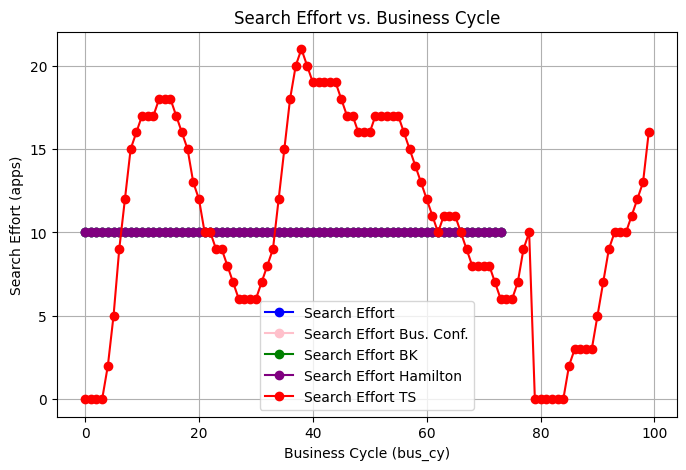

In [11]:
search_effort_dat = pd.read_csv("data/quarterly_search_ts.csv")
search_effort_dat['DATE'] = pd.to_datetime(search_effort_dat['year'].astype(str) + '-' + (search_effort_dat['quarter'] * 3 - 2).astype(str) + '-01')
search_effort_np = np.array(search_effort_dat['value_smooth'])
search_effort_np = search_effort_np/search_effort_np.mean()

# Define a range of bus_cy values  # Generates 100 values from 0 to 1
search_effort_values = [search_effort(0, b, False) for b in gdp_dat]  # Apply function
search_effort_bus_conf_values = [search_effort(0, b, False) for b in bus_conf_dat]  # Apply function
search_effort_bk_values = [search_effort(0, b, False) for b in gdp_dat_bk]  # Apply function
search_effort_hamilton_values = [search_effort(0, b, False) for b in gdp_dat_hamilton]  # Apply function
# def search_effort_ts(t_unemp, se):
#     apps = max(0, round(10 - 100*(1-se)))
#     # if discouraged:
#     #     apps = round(a_stable/((t_unemp)**2 + 1)) + 1
#     return apps
search_effort_values_dyn = [search_effort_ts(0, b) for b in search_effort_np]

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(range(len(search_effort_values)), search_effort_values, marker='o', linestyle='-', color='b', label="Search Effort")
plt.plot(range(len(search_effort_bus_conf_values)), search_effort_bus_conf_values, marker='o', linestyle='-', color='pink', label="Search Effort Bus. Conf.")
plt.plot(range(len(search_effort_bk_values)), search_effort_bk_values, marker='o', linestyle='-', color='g', label="Search Effort BK")
plt.plot(range(len(search_effort_hamilton_values)), search_effort_hamilton_values, marker='o', linestyle='-', color='purple', label="Search Effort Hamilton")

plt.plot(range(len(search_effort_values_dyn)), search_effort_values_dyn, marker='o', linestyle='-', color='r', label="Search Effort TS")
plt.xlabel("Business Cycle (bus_cy)")
plt.ylabel("Search Effort (apps)")
plt.title("Search Effort vs. Business Cycle")
plt.legend()
plt.grid(True)
plt.show()



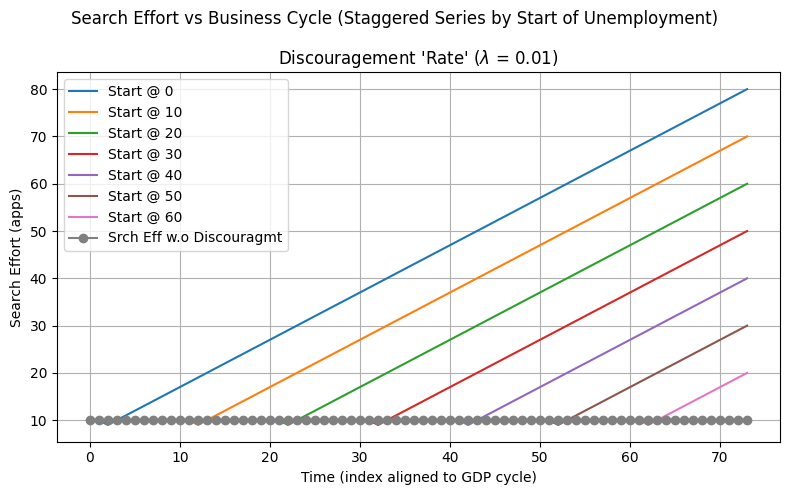

In [12]:
# Setup a single plot
fig, ax = plt.subplots(figsize=(8, 5))

# Arbitrary starting points
start_points = [0, 10, 20, 30, 40, 50, 60]
series_dict = {}

for start in start_points:
    efforts = []
    for t_unemp, bus_cy in enumerate(bus_conf_dat[start:]):
        apps = search_effort(t_unemp, bus_cy, True)  # uses fixed lambda `a` internally
        efforts.append(apps)
    series_dict[f"Start @ {start}"] = {
        "x": list(range(start, start + len(efforts))),
        "y": efforts
    }

# Plot each series
for label, data in series_dict.items():
    ax.plot(data["x"], data["y"], label=label)

# Optional: plot a reference series
ax.plot(range(len(search_effort_values)), search_effort_values, marker='o', linestyle='-', color='grey', label="Srch Eff w.o Discouragmt")

# Labels and title
ax.set_xlabel("Time (index aligned to GDP cycle)")
ax.set_ylabel("Search Effort (apps)")
ax.set_title(f"Discouragement 'Rate' ($\lambda$ = 0.01)")
ax.legend(loc='upper left')
ax.grid(True)

plt.suptitle("Search Effort vs Business Cycle (Staggered Series by Start of Unemployment)")
plt.tight_layout()
plt.show()

In [13]:
####################
# Model Run ########
####################
def run_single_local( #behav_spec, 
                    d_u, 
                    d_v,
                    gamma_u,
                    gamma_v,
                    otj,
                    cyc_otj, 
                    cyc_ue, 
                    disc,
                    mod_data = mod_data, 
                    net_temp = net_temp, 
                    vacs = vacs, 
                    time_steps = len(gdp_dat), # set equal to length of gdp_data
                    delay = 0,
                    gdp_data = gdp_dat,
                    bus_confidence_dat = bus_conf_dat,
                    simple_res = True):
    
    """ Runs the model once
    Argsuments:
       behav_spec: whether or not to run the behavioural model
       data: data required of initialise function  
       time_steps: Number of time steps for single model run
       d_u: parameter input to separation probability
       d_v: parameter input to vacancy opening probability

    Returns:
       dataframe of model run results
    """
    # Records variables of interest for plotting
    # Initialise deepcopy occupational mobility network
    #print(behav_spec)
    record = [np.sum(np.concatenate((np.zeros((464, 1)), 
                                    mod_data['employment'].to_numpy(), 
                                    mod_data['unemployment'].to_numpy(), 
                                    mod_data['employment'].to_numpy() + mod_data['unemployment'].to_numpy(),
                                    mod_data['vacancies'].to_numpy(), 
                                    np.zeros((464, 1)),
                                    mod_data['demand_target'].to_numpy(),
                                    mod_data['demand_target'].to_numpy(),
                                    np.zeros((464, 1)),
                                    np.zeros((464, 1))), axis = 1), 
                                    axis = 0)]
    
    #print(parameter['vacs'])
    vacs_temp = deepcopy(vacs)
    net = deepcopy(net_temp)
    for t in range(time_steps):
        #if t == 1:
            #print(behav_spec)
        curr_bus_cy = gdp_data[t]
        bus_conf = bus_confidence_dat[t]
        ue_bc = curr_bus_cy
        if not cyc_ue:
            ue_bc = 1
        # search_eff_curr = search_eff_ts[t]
        # Ensure number of workers in economy has not changed
        #tic = time.process_time()
        emp_seekers = 0
        unemp_seekers = 0
        for occ in net:
            ### APPLICATIONS
            # Questions to verify:
            # - CANNOT be fired and apply in same time step ie. time_unemployed > 0
            # - CAN be rejected and apply in the same time step - no protected attribute
            # isolate list of vacancies in economy that are relevant to the occupation
            # - avoids selecting in each search_and_apply application
            r_vacs = [vac for vac in vacs_temp if occ.list_of_neigh_bool[vac.occupation_id]]          
    
            for u in occ.list_of_unemployed:
                unemp_seekers += 1
                # this one if only using simple scaling factor for the search effort
                u.search_and_apply(net, r_vacs, disc, ue_bc)
                # use the following if we wish to incorporate the entire TS of search effort
                #u.search_and_apply(net, r_vacs, behav_spec, search_eff_curr)
            
            if otj:
                # For both models, a mean of 40% of employed workers are searching for new jobs
                # This fluctuates with the business cycle in the behavioural model in line with gdp
                if cyc_otj:
                    search_scaling = curr_bus_cy*0.07
                # Static mean in the non-behavioural model
                else:
                    search_scaling = 0.07
                for e in random.sample(occ.list_of_employed, int(search_scaling*len(occ.list_of_employed))):
                    emp_seekers += 1
                    e.emp_search_and_apply(net, r_vacs, disc)

            ### SEPARATIONS
            try:
                occ.separate_workers(d_u, gamma_u, curr_bus_cy)
            except Exception as e:
                return np.inf

        ### HIRING
        # Ordering of hiring randomised to ensure list order does not matter in filling vacancies...
        # Possibly still introduces some bias...this seems to be where the "multiple offer" challenge Maria mentioned comes from
        # ....might be better to do this using an unordered set?
        for v_open in sorted(vacs_temp,key=lambda _: random.random()):
            # Removes any applicants that have already been hired in another vacancy
            v_open.applicants[:] = [app for app in v_open.applicants if not(app.hired)]
            v_open.time_open += 1
            if len(v_open.applicants) > 0:
                v_open.hire(net)
                v_open.filled = True
                #vacs.remove(v_open)
                assert(len(v_open.applicants) == 0)
            else:
                pass

        vacs_temp = [v for v in vacs_temp if not(v.filled) and v.time_open <= 1] 

        # Reset counters for record in time t
        empl = 0 
        unemp = 0
        n_ltue = 0
        curr_demand = 0
        t_demand = 0

        ### OPEN VACANCIES
        # Update vacancies after all shifts have taken place
        # Could consider making this a function of the class itself?
        for occ in net:
            # Update time_unemployed and long-term unemployed status of unemployed workers
            # Remove protected "hired" attribute of employed workers
            occ.update_workers()
            # Assert that all unemployed people have spent 1 or more time periods unemployed
            assert(sum([worker.time_unemployed <= 0 for worker in occ.list_of_unemployed]) == 0)
            # Assert that all employed people have spent 0 time periods unemployed
            assert(sum([worker.time_unemployed <= 0 for worker in occ.list_of_employed]) == len(occ.list_of_employed))
            emp = len(occ.list_of_employed)
            occ.current_demand = (len([v_open for v_open in vacs_temp if v_open.occupation_id == occ.occupation_id]) + emp)
            #occ.current_demand = bus_cycle_demand(len([v_open for v_open in vacs_temp if v_open.occupation_id == occ.occupation_id]) + emp, t, bus_amp, bus_cycle_len)
            vac_prob = d_v + ((gamma_v * max(0, occ.target_demand*(bus_conf) - occ.current_demand)) / (emp + 1))
            #vac_prob = d_v + ((1 - d_v) * (gamma_v * max(0, occ.target_demand - occ.current_demand))) / (emp + 1)
            vacs_create = emp*int(vac_prob) + int(np.random.binomial(emp, vac_prob%1))
            for v in range(vacs_create):
                vacs_temp.append(vac(occ.occupation_id, [], occ.wage, False, 0))

            empl += len(occ.list_of_employed) 
            unemp += len(occ.list_of_unemployed)
            n_ltue += sum(wrkr.longterm_unemp for wrkr in occ.list_of_unemployed)
            curr_demand += occ.current_demand
            t_demand += occ.target_demand*bus_conf

        ### UPDATE INDICATOR RECORD
        record = np.append(record, 
                               np.array([[t+1, empl, unemp, empl + unemp, len(vacs_temp), n_ltue, curr_demand, t_demand, emp_seekers, unemp_seekers]]), 
                               axis = 0)

    data = {'UER': record[delay:,2]/record[delay:,3], 
            'VACRATE': record[delay:,4]/(record[delay:,4] + record[delay:,1])}

    if simple_res:
        return data
    else:
        return record[1:,:], net, data

#########################################
# Wrapper for pyabc ########
#########################################
def pyabc_run_single(parameter):     
    res = run_single_local(**parameter)
    return res 


In [14]:
def harmonise_length(x, y):
    """
    GDP data used to calibrate has lower periodicity than the UER and VACRATE used for calibration. The following linearly interpolates the simulated output to match the frequency of the UER and Vacancy Rate data
    Harmonises the length of the time series to compare to each other. 
        
    Args:
        x (dict): Simulated data with keys "UER" and "VACRATE".
        y (dict): Real-world data with keys "UER" and "VACRATE".
    
    Returns:
        expanded_format: x expanded via linear interpolation - now of same length as y (observed time series of UER and vacancy rate)
    """
    expanded_format = pd.DataFrame({
        col: np.interp(
            np.linspace(0, len(x[col]) - 1, len(y[col])),
            np.linspace(0, len(x[col]) - 1, len(x[col])),
            x[col]
            )
            for col in x.keys()
            })
    return expanded_format

def distance_weighted(x, y): #weight_shape=0, weight_mean=1):
    x_ = harmonise_length(x, y)
    
    # Normalized SSE using variance
    uer_sse = np.sum((x_["UER"] - y["UER"])**2) / np.var(y["UER"])
    vacrate_sse = np.sum((x_["VACRATE"] - y["VACRATE"])**2) / np.var(y["VACRATE"])

    # Weighted combination
    dist = (np.sqrt(uer_sse) + np.sqrt(vacrate_sse))
    return dist


In [15]:
calib_list = {
    # "nonbehav": {"otj": False, # has been run
    #                        "cyc_otj": False, 
    #                        "cyc_ue": False, 
    #                        "disc": False,
    #                        "bus_confidence_dat": bus_conf_dat},
              "otj_nonbehav": {"otj": True, # has been run
                           "cyc_otj": False, 
                           "cyc_ue": False, 
                           "disc": False, 
                           "bus_confidence_dat": gdp_dat},
    #           "otj_cyclical_e": {"otj": True,
    #                        "cyc_otj": True, 
    #                        "cyc_ue": False, 
    #                        "disc": False,
    #                        "bus_confidence_dat": bus_conf_dat},
            #   "otj_cyclical_ue ": {"otj": True,
            #                "cyc_otj": False, 
            #                "cyc_ue": True, 
            #                "disc": False},
            #   "otj_cyclical_e_ue": {"otj": True,
            #                "cyc_otj": True, 
            #                "cyc_ue": True, 
            #                "disc": False},
              "otj_cyclical_e_disc": {"otj": True,
                           "cyc_otj": True, 
                           "cyc_ue": False, 
                           "disc": True,
                           "bus_confidence_dat": gdp_dat} #,
              # "otj_cyclical_ue_disc": {"otj": True,
              #              "cyc_otj": False, 
              #              "cyc_ue": True, 
              #              "disc": True},
              # "otj_cyclical_e_ue_disc": {"otj": True,
              #              "cyc_otj": True, 
              #              "cyc_ue": True, 
              #              "disc": True}
            #  "otj_disc": {"otj": True,
            #                "cyc_otj": False, 
            #                "cyc_ue": False, 
            #                "disc": True,
            #                "bus_confidence_dat": bus_conf_dat}
            }

In [16]:
observation = macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset = ["UNRATE", "VACRATE"]).reset_index()

if calib:
    prior = pyabc.Distribution(d_u = pyabc.RV("uniform", 0.00001, 0.06),
                        d_v = pyabc.RV("uniform", 0.00001, 0.06),
                        gamma_u = pyabc.RV("uniform", 0.00001, 1.7),
                        gamma_v = pyabc.RV("uniform", 0.00001, 1)) 
    
    
    # Define possible distance functions and behav_spec values
    behav_spec_values = [False, True]

    # CSV filename
    csv_filename = os.path.expanduser(path + f"output_07_05/calibrated_params_all.csv")

    # Ensure CSV file starts with headers
    if not os.path.exists(csv_filename):
        with open(csv_filename, "w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(["Parameter", "Value", "otj", "cyc_otj", "cyc_ue", "disc", "Timestamp"])


    for name, temp_params in calib_list.items():
        print(f"Running calibration for {name}")

        # Create a new version with different default values
        temp_run = partial(run_single_local, **temp_params)
            
        #########################################
        # Wrapper for pyabc ########
        #########################################
        def pyabc_run_single(parameter):     
            res = temp_run(**parameter)
            return res

        # Set up ABC calibration
        calib_sampler = pyabc.sampler.MulticoreEvalParallelSampler(n_procs=3)
        
        abc = pyabc.ABCSMC(pyabc_run_single, prior, distance_weighted, population_size=100, sampler=calib_sampler)

        db_path = os.path.join(tempfile.gettempdir(), f"test_{name}.db")
        # The following creates the "reference" values from the observed data - I pull the non-recession or expansion period from 2010-2019.
        #observation = macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset = ["UNRATE", "VACRATE"]).reset_index()

        data = {'UER': np.array(observation['UER']),
            'VACRATE': np.array(observation['VACRATE'])}
    
        abc.new("sqlite:///" + db_path, data)

        history = abc.run(minimum_epsilon=0.1, max_nr_populations=15)

        # Extract parameter estimates
        df, w = history.get_distribution(t=history.max_t)
        final_params = {
            "d_u": np.sum(df["d_u"] * w),
            "d_v": np.sum(df["d_v"] * w),
            "gamma_u": np.sum(df["gamma_u"] * w),
            "gamma_v": np.sum(df["gamma_v"] * w),
        }

        # Save parameter estimates to CSV
        with open(csv_filename, "a", newline="") as file:
            writer = csv.writer(file)
            for param, value in final_params.items():
                writer.writerow([param, value, temp_params['otj'], temp_params['cyc_otj'], temp_params['cyc_ue'], temp_params['disc'], datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")])

        # Generate and save plots
        plot_directory = os.path.expanduser(path + "output_07_05/")
        os.makedirs(plot_directory, exist_ok=True)
        plot_filename_base = plot_directory + f"calibration_{name}"
        
        # KDE Matrix
        plt.figure()
        plot_kde_matrix(
            df, 
            w, 
            limits={"d_u": (0.00001, 0.1), "d_v": (0.00001, 0.1), "gamma_u": (0.00001, 2), "gamma_v": (0.00001, 1)}, 
            refval=final_params, 
            names={"d_u": r"$\delta_u$", "d_v": r"$\delta_v$", "gamma_u": r"$\gamma_u$", "gamma_v": r"$\gamma_v$"}
        )
        plt.savefig(f"{plot_filename_base}_kde_matrix.png", bbox_inches='tight', pad_inches=0.5)
        plt.close()

        # Joint KDE Plot for d_u and d_v
        sns.jointplot(x="d_u", y="d_v", kind="kde", data=df, weights=w, cmap="viridis_r", marginal_kws={'fill': True})
        plt.xlabel(r'$\delta_u$')
        plt.ylabel(r'$\delta_v$')
        plt.axvline(x=np.sum(df["d_u"] * w), color="green", linestyle='dashed')
        plt.axhline(y=np.sum(df["d_v"] * w), color="green", linestyle='dashed')
        plt.suptitle(r"Kernel Density Estimate: $\delta_u$, $\delta_v$", y=1.02)
        plt.savefig(f"{plot_filename_base}_joint_delta.png", bbox_inches='tight', pad_inches=0.5)
        plt.close()

        # Joint KDE Plot for gamma_u and gamma_v
        sns.jointplot(x="gamma_u", y="gamma_v", kind="kde", data=df, weights=w, cmap="viridis_r", marginal_kws={'fill': True, 'color': 'green'})
        plt.xlabel(r'$\gamma_u$')
        plt.ylabel(r'$\gamma_v$')
        plt.axvline(x=np.sum(df["gamma_u"] * w), color="green", linestyle = 'dashed')
        plt.axhline(y=np.sum(df["gamma_v"] * w), color="green", linestyle='dashed')
        plt.suptitle(r"Kernel Density Estimate: $\gamma_u$, $\gamma_u$", y=1.02)
        plt.savefig(f"{plot_filename_base}_joint_gamma.png", bbox_inches='tight', pad_inches=0.5)
        plt.close()

        # Simulation Results Plot
        fig, axes = plt.subplots(2, 1, sharex=True)
        fig.set_size_inches(8, 12)
        n = 15  # Number of samples to plot from each category
        alpha = 0.5

        sum_stats = history.get_weighted_sum_stats_for_model(m=0, t=history.max_t)
        calib_date = [pd.to_datetime(calib_date[0]), pd.to_datetime(calib_date[1])]
        buffer = pd.DateOffset(years=1)

        for stored in sum_stats[1][:n]:
            stored_ = harmonise_length(stored, observation)
            date_range = pd.date_range(start=calib_date[0], end=calib_date[1], periods=len(stored_))
            axes[0].plot(date_range, stored_["UER"], color="green", alpha=alpha)
            axes[1].plot(date_range, stored_["VACRATE"], color="green", alpha=alpha)

        #for ax in axes[0]:
        observation.plot(x = "DATE", y="UER", ax=axes[0], color="black", linewidth=1.5)
        axes[0].legend().set_visible(False)
        axes[0].set_ylabel("UER")
        axes[0].set_xlim([calib_date[0], calib_date[1]])

        #for ax in axes[1]:
        observation.plot(x = "DATE", y = "VACRATE", ax=axes[1], color="black", linewidth=1.5)
        axes[1].legend().set_visible(False)
        axes[1].set_ylabel("VACANCY RATE")
        axes[1].set_xlim([calib_date[0] - buffer, calib_date[1] + buffer])
        #ax.yaxis.set_label_position("right")

        fig.suptitle(f"Simulation Results using Parameters from Posterior (sampled & accepted)_{name}")

        fig.legend(
            [
                plt.plot([0], color="green")[0],
                plt.plot([0], color="black")[0],
            ],
            ["Stored, accepted", "Observation"],
            bbox_to_anchor=(0.5, 0.9),
            loc="lower center",
            ncol=4,
        )
        plt.savefig(f"{plot_filename_base}_sim_results.png", bbox_inches='tight', pad_inches=0.5)
        plt.close()

    print("Calibration complete. Results saved to CSV and plots saved as images.")

ABC.Sampler INFO: Parallelize sampling on 3 processes.
ABC.History INFO: Start <ABCSMC id=2, start_time=2025-05-08 00:58:50>
ABC INFO: Calibration sample t = -1.


Running calibration for otj_nonbehav


ABC INFO: t: 0, eps: 9.69518147e+01.
ABC INFO: Accepted: 100 / 158 = 6.3291e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 6.28209047e+01.
ABC INFO: Accepted: 100 / 201 = 4.9751e-01, ESS: 6.5157e+01.
ABC INFO: t: 2, eps: 4.82057354e+01.
ABC INFO: Accepted: 100 / 261 = 3.8314e-01, ESS: 7.1180e+01.
ABC INFO: t: 3, eps: 4.07116952e+01.
ABC INFO: Accepted: 100 / 203 = 4.9261e-01, ESS: 3.6826e+01.
ABC INFO: t: 4, eps: 3.67527332e+01.
ABC INFO: Accepted: 100 / 197 = 5.0761e-01, ESS: 7.9133e+01.
ABC INFO: t: 5, eps: 3.20064598e+01.
ABC INFO: Accepted: 100 / 192 = 5.2083e-01, ESS: 6.8377e+01.
ABC INFO: t: 6, eps: 3.06650594e+01.
ABC INFO: Accepted: 100 / 174 = 5.7471e-01, ESS: 7.7795e+01.
ABC INFO: t: 7, eps: 2.90877964e+01.
ABC INFO: Accepted: 100 / 226 = 4.4248e-01, ESS: 5.5785e+01.
ABC INFO: t: 8, eps: 2.81590240e+01.
ABC INFO: Accepted: 100 / 253 = 3.9526e-01, ESS: 7.9129e+01.
ABC INFO: t: 9, eps: 2.74791033e+01.
ABC INFO: Accepted: 100 / 244 = 4.0984e-01, ESS: 7.7091e+01.
ABC INFO: t: 10, eps

Running calibration for otj_cyclical_e_disc


ABC INFO: t: 0, eps: 2.80812532e+02.
ABC INFO: Accepted: 100 / 192 = 5.2083e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 1.62511260e+02.
ABC INFO: Accepted: 100 / 264 = 3.7879e-01, ESS: 6.9418e+01.
ABC INFO: t: 2, eps: 1.16860683e+02.
ABC INFO: Accepted: 100 / 195 = 5.1282e-01, ESS: 7.4265e+01.
ABC INFO: t: 3, eps: 8.03754701e+01.
ABC INFO: Accepted: 100 / 190 = 5.2632e-01, ESS: 7.2973e+01.
ABC INFO: t: 4, eps: 5.68401424e+01.
ABC INFO: Accepted: 100 / 206 = 4.8544e-01, ESS: 6.6752e+01.
ABC INFO: t: 5, eps: 4.50102612e+01.
ABC INFO: Accepted: 100 / 246 = 4.0650e-01, ESS: 6.0996e+01.
ABC INFO: t: 6, eps: 4.03748168e+01.
ABC INFO: Accepted: 100 / 224 = 4.4643e-01, ESS: 7.4780e+01.
ABC INFO: t: 7, eps: 3.64900461e+01.
ABC INFO: Accepted: 100 / 293 = 3.4130e-01, ESS: 7.3183e+01.
ABC INFO: t: 8, eps: 3.38657919e+01.
ABC INFO: Accepted: 100 / 248 = 4.0323e-01, ESS: 7.6151e+01.
ABC INFO: t: 9, eps: 3.19483982e+01.
ABC INFO: Accepted: 100 / 263 = 3.8023e-01, ESS: 5.0693e+01.
ABC INFO: t: 10, eps

Calibration complete. Results saved to CSV and plots saved as images.


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [17]:
# # observation = macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset = ["UNRATE", "VACRATE"]).reset_index()
# # Load calibrated parameters from CSV
# param_df = pd.read_csv(path + "output_18_04/dist_50_50/calibrated_params_all.csv")
# # Sort by Timestamp in descending order
# param_df = param_df.sort_values(by='Timestamp', ascending=False)

# # Keep only the latest version of each parameter by removing duplicates
# param_df = param_df.drop_duplicates(subset=['Parameter', 'Behav_Mode'], keep='first')
# print(param_df)

# final_params = {'mod_data': mod_data, 
#             'net_temp': net_temp,
#             'vacs': vacs, 
#             'time_steps': len(gdp_dat),
#             'delay': 0,
#             'gdp_data': gdp_dat,
#             'simple_res': False}

# # Define the plot size
# final_params.update({'behav_spec': False})

# # Create independent copies for non-behavioral and behavioral parameter sets
# non_behav_params = deepcopy(final_params)
# non_behav_params.update(
#     param_df[param_df['Behav_Mode'] == False].set_index('Parameter')['Value'].to_dict()
# )

# sim_record_f, sim_net_f, sum_stats_f = run_single_local(**non_behav_params)

# behav_params = deepcopy(final_params)
# behav_params.update(
#     param_df[param_df['Behav_Mode'] == True].set_index('Parameter')['Value'].to_dict()
# )
# behav_params.update({'behav_spec': True})  # Ensure correct behavior flag

# # Run the model for behavioral case
# sim_record_t, sim_net_t, sum_stats_t = run_single_local(**behav_params)


In [18]:
# behav_params = deepcopy(final_params)
# behav_params.update(
#     param_df[param_df['Behav_Mode'] == True].set_index('Parameter')['Value'].to_dict()
# )
# behav_params.update({'behav_spec': True,
#                      'search_eff_ts': search_effort_np}) 

# # Run the model for behavioral case
# sim_record_t_ts, sim_net_t_ts, sum_stats_t_ts = run_single_local(**behav_params)

# ue_vac_t_ts = plot_records(sim_record_t_ts, calib_date[0], calib_date[1])